
Tugas Take Home Test Penjelasan dataset, algoritme EM dan PPCA serta kode program, dijelaskan pada Laporan

Nama:Irmawati Carolina

NIM:G6601231011

Email:irmawati_carolinairmawati@apps.ipb.ac.id

---



In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [2]:

# Function to initialize parameters for GMM
def initialize_parameters(data, n_clusters):
    n_samples, n_features = data.shape
    means = data[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.cov(data.T) for _ in range(n_clusters)]
    proportions = np.ones(n_clusters) / n_clusters
    return means, covariances, proportions

# E Step
def e_step(data, means, covariances, proportions, n_clusters):
    n_samples = data.shape[0]
    responsibilities = np.zeros((n_samples, n_clusters))

    for i in range(n_clusters):
        responsibilities[:, i] = proportions[i] * multivariate_normal.pdf(data, mean=means[i], cov=covariances[i])

    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# M Step
def m_step(data, responsibilities, n_clusters):
    n_samples, n_features = data.shape
    weights = responsibilities.sum(axis=0)

    means = np.array([np.average(data, axis=0, weights=responsibilities[:, i]) for i in range(n_clusters)])
    covariances = []
    for i in range(n_clusters):
        diff = data - means[i]
        weighted_diff = responsibilities[:, i][:, np.newaxis] * diff
        covariances.append(np.dot(weighted_diff.T, diff) / weights[i])

    proportions = weights / n_samples
    return means, covariances, proportions

# PPCA Implementation
def ppca(data, n_components):
    n_samples, n_features = data.shape
    X = data.T @ data
    _, S, Vt = np.linalg.svd(X)
    principal_components = Vt[:n_components].T
    explained_variance = np.sum(S[:n_components]) / np.sum(S)
    return principal_components, explained_variance

# GMM using EM
def gmm_em(data, n_clusters, n_iters):
    means, covariances, proportions = initialize_parameters(data, n_clusters)

    for _ in range(n_iters):
        responsibilities = e_step(data, means, covariances, proportions, n_clusters)
        means, covariances, proportions = m_step(data, responsibilities, n_clusters)

    return means, covariances, proportions


In [4]:

# Load and clean the data
file_path = 'water_dataX.csv'
water_data = pd.read_csv(file_path, encoding='ISO-8859-1')
water_data_cleaned = water_data.apply(pd.to_numeric, errors='coerce').fillna(method='ffill')
water_data_cleaned = water_data_cleaned.drop(['STATION CODE', 'LOCATIONS', 'STATE', 'year'], axis=1)



In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming water_data_cleaned is your dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(water_data_cleaned)

# Initialize PCA and fit it to the scaled data
pca = PCA(n_components=2)  # Adjust n_components as needed
pca.fit(scaled_data)

# Transform the data using PCA
pca_data = pca.transform(scaled_data)


In [8]:
# Implement Gaussian Mixture Model for clustering
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
# covariance_type='full' assumes full covariance matrices
gmm.fit(scaled_data)
cluster_labels = gmm.predict(scaled_data)

# Adding the cluster labels to the dataset
water_data_clustered = water_data_cleaned.copy()
water_data_clustered['Cluster'] = cluster_labels

In [9]:
# Apply PPCA for variable analysis (example: 2 components)

pca = PCA(n_components=4)  # Using 2 components
pca.fit(scaled_data)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


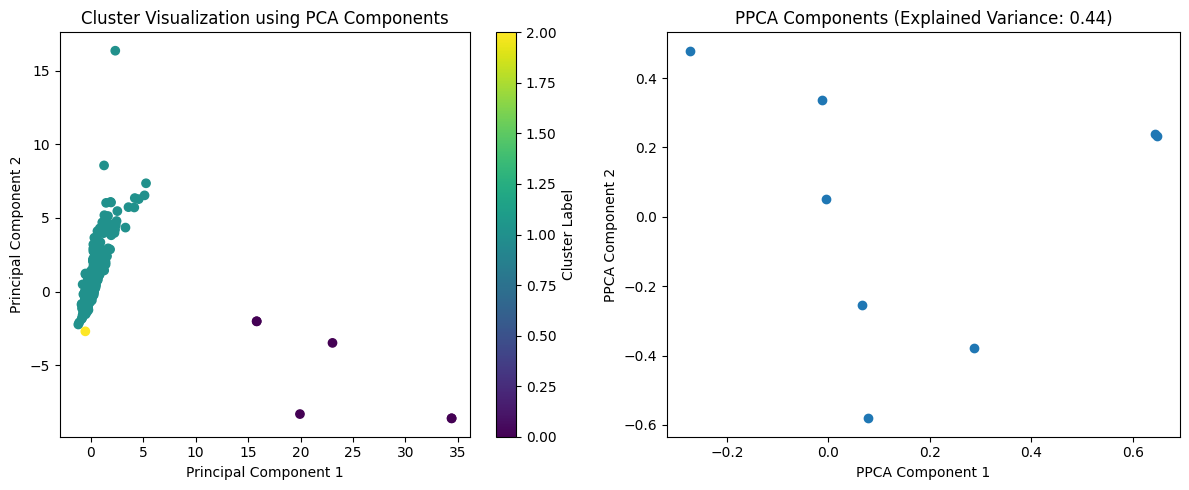

In [10]:
# Visualize the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization using PCA Components')
plt.colorbar(label='Cluster Label')

plt.subplot(1, 2, 2)
# Implement PPCA for variable analysis
n_components_ppca = 2
X = scaled_data.T @ scaled_data
_, S, Vt = np.linalg.svd(X)
principal_components = Vt[:n_components_ppca].T
explained_variance = np.sum(S[:n_components_ppca]) / np.sum(S)
plt.scatter(principal_components[:, 0], principal_components[:, 1], marker='o')
plt.xlabel('PPCA Component 1')
plt.ylabel('PPCA Component 2')
plt.title('PPCA Components (Explained Variance: {:.2f})'.format(explained_variance))

plt.tight_layout()
plt.show()

In [11]:
# Creating a DataFrame for loadings
loadings_df = pd.DataFrame(data=loadings, columns=['PC1', 'PC2','PC3','PC4'], index=water_data_cleaned.columns)


# Displaying results
print("First few rows of clustered data:\n", water_data_clustered.head())
print("\nLoadings for PCA components:\n", loadings_df)
print("\nExplained variance by each PCA component:", pca.explained_variance_ratio_)

First few rows of clustered data:
    Temp  D.O. (mg/l)   PH  CONDUCTIVITY (µmhos/cm)  B.O.D. (mg/l)  \
0  30.6          6.7  7.5                    203.0       7.371785   
1  29.8          5.7  7.2                    189.0       2.000000   
2  29.5          6.3  6.9                    179.0       1.700000   
3  29.7          5.8  6.9                     64.0       3.800000   
4  29.5          5.8  7.3                     83.0       1.900000   

   NITRATENAN N+ NITRITENANN (mg/l)  FECAL COLIFORM (MPN/100ml)  \
0                               0.1                        11.0   
1                               0.2                      4953.0   
2                               0.1                      3243.0   
3                               0.5                      5382.0   
4                               0.4                      3428.0   

   TOTAL COLIFORM (MPN/100ml)Mean  Cluster  
0                            27.0        1  
1                          8391.0        1  
2           